# Chapter 5 Exercises. The Many Variables & The Spurious Waffles

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import altair as alt

alt.renderers.enable("mimetype")  # support rendering on github

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression

import statreth as sr
from statreth.utils import suppress_subprocess_output

## 5M1

Invent your own example of a spurious correlation. An outcome variable should be correlated
with both predictor variables. But when both predictors are entered in the same model, the correlation
between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

Consider a toy model where Exercise `E` and Diet `D` influences Sleep Quality `S`.
```
E─────►D
│      │
│      ▼
└─────►S
```

When stratified by `D`, it would block `E->D->S` path and reveal direct influence of `E` on `S`.

In [3]:
# generate synthetic data according to the DAG
bED = 2  # direct effect of Exercies on Diet
bES = 1  # direct effect of Exercise on Sleep
bDS = 1  # direct effect of Diet on Sleep
n = 500  # number of individuals

E = np.random.normal(0, 1, size=n)  # Exercise
D = np.random.normal(bED * E, 1)  # Diet
S = np.random.normal(bES * E + bDS * D)  # Sleep

sleep_df = pd.DataFrame({"exercise": E, "diet": D, "sleep": S})
sleep_df.head(5)

,exercise,diet,sleep
0,2.111346,5.698053,8.209991
1,-0.582237,-1.274719,-3.250618
2,-1.256341,-2.351610,-3.288208
3,0.373957,2.540198,0.772656
4,0.725394,1.928754,2.431238


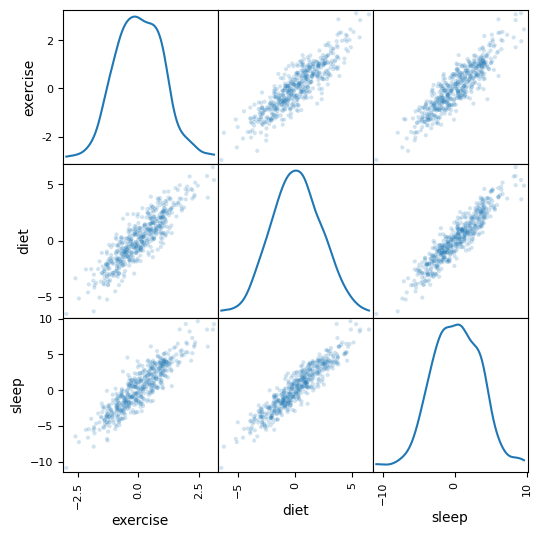

In [4]:
# confirm that all variables are correlated
scatter_matrix(sleep_df, alpha=0.2, figsize=(6, 6), diagonal="kde");

In [5]:
# fit model S = f(E)
m = LinearRegression()

x = sleep_df["exercise"].to_numpy().reshape(-1, 1)
y = sleep_df["sleep"].to_numpy()
m.fit(x, y)
print(f"estimated slope bES={m.coef_[0]}")

estimated slope bES=2.942110640440845


In [6]:
# fit model S = f(E, D), expect to see reduced bES term
m = LinearRegression()

x = sleep_df[["exercise", "diet"]].to_numpy()
y = sleep_df["sleep"].to_numpy()
m.fit(x, y)
print(f"estimated slope bES={m.coef_[0]}")
print(f"estimated slope bDS={m.coef_[1]}")

estimated slope bES=1.0819765654265436
estimated slope bDS=0.9450667995544093


## 5M2

Invent your own example of a masked relationship. An outcome variable should be correlated
with both predictor variables, but in opposite directions. And the two predictor variables should be
correlated with one another.

Consider the same DAG from 5M1 where `E` - Exercise, `D` - Diet and `S` - Sleep Quality.
```
E─────►D
│      │
│      ▼
└─────►S
```

In [7]:
# Change coefficients to have positive correlation between E and S and negative between D and S
bED = 1  # direct effect of Exercies on Diet
bES = 1  # direct effect of Exercise on Sleep
bDS = -1  # direct effect of Diet on Sleep
n = 500  # number of individuals

E = np.random.normal(0, 1, size=n)  # Exercise
D = np.random.normal(bED * E, 1)  # Diet
S = np.random.normal(bES * E + bDS * D)  # Sleep

sleep2_df = pd.DataFrame({"exercise": E, "diet": D, "sleep": S})
sleep2_df.head(5)

,exercise,diet,sleep
0,-0.761310,-1.235889,0.544907
1,0.908256,-1.568181,1.536612
2,-1.786212,0.308801,-2.743701
3,-1.129974,-0.524117,-0.435655
4,-1.375093,-1.247879,-1.352338


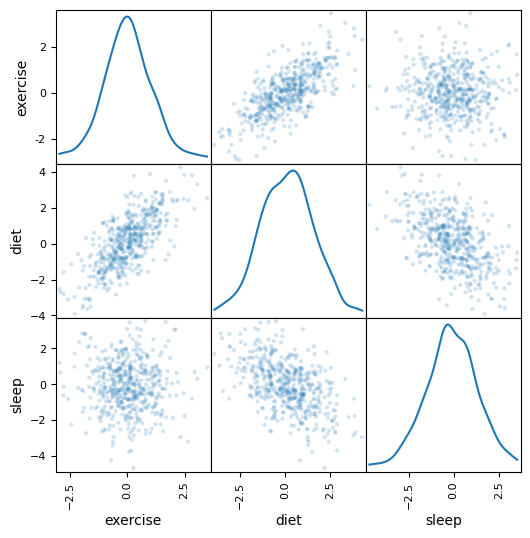

In [8]:
# confirm that E->D is uncorrelated because 2 branches of the DAG cancel each other
scatter_matrix(sleep2_df, alpha=0.2, figsize=(6, 6), diagonal="kde");

In [9]:
# fit model S = f(E)
m = LinearRegression()

x = sleep2_df["exercise"].to_numpy().reshape(-1, 1)
y = sleep2_df["sleep"].to_numpy()
m.fit(x, y)
print(f"estimated slope bES={m.coef_[0]}")

estimated slope bES=-0.035630205697897134


In [10]:
# fit model S = f(E, D), expect to see increased bES term
m = LinearRegression()

x = sleep2_df[["exercise", "diet"]].to_numpy()
y = sleep2_df["sleep"].to_numpy()
m.fit(x, y)
print(f"estimated slope bES={m.coef_[0]}")
print(f"estimated slope bDS={m.coef_[1]}")

estimated slope bES=0.9445726795070858
estimated slope bDS=-0.9519252570580979


## 5M3

It is sometimes observed that the best predictor of fire risk is the presence of firefighters—
States and localities with many firefighters also have more fires. Presumably firefighters do not cause
fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the
same reversal of causal inference in the context of the divorce and marriage data. How might a high
divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship, using
multiple regression?

High divorce rate `D` would increase unmarried population which in turn would presumably increase
second marriage rate `M2` contributing to total marriage rate `M`.

```
D───►M2───►M
│          ▲
│          │
└────?─────┘
```

So we can build a regression model `M = f(D, M2)` where we would expect to see little direct impact of `D -> M`

## 5M4

In the divorce data, States with high numbers of Mormons (members of The Church of Jesus
Christ of Latter-day Saints, LDS) have much lower divorce rates than the regression models expected.
Find a list of LDS population by State and use those numbers as a predictor variable, predicting divorce rate using marriage rate, median age at marriage, and percent LDS population (possibly standardized). You may want to consider transformations of the raw percent LDS variable.

In [11]:
waffle_df = pd.read_csv("../data/WaffleDivorce.csv", delimiter=";")
waffle_df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [12]:
# Augment data with LDS percentage.
# The Church of Jesus Christ of Latter-day Saints (LDS) percentage of the population in each state
# from https://xcelab.net/rmpubs/rethinking/rethinking_solutions_2.pdf
waffle_df["LDS"] = [
    0.75,
    4.53,
    6.18,
    1,
    2.01,
    2.82,
    0.43,
    0.55,
    0.38,
    0.75,
    0.82,
    5.18,
    26.35,
    0.44,
    0.66,
    0.87,
    1.25,
    0.77,
    0.64,
    0.81,
    0.72,
    0.39,
    0.44,
    0.58,
    0.72,
    1.14,
    4.78,
    1.29,
    0.61,
    0.37,
    3.34,
    0.41,
    0.82,
    1.48,
    0.52,
    1.2,
    3.85,
    0.4,
    0.37,
    0.83,
    1.27,
    0.75,
    1.21,
    67.97,
    0.74,
    1.13,
    3.99,
    0.92,
    0.44,
    11.5,
]

In [13]:
# apply log to LDS to compress its range
waffle_df["logLDS"] = np.log10(waffle_df["LDS"])

In [14]:
# prepare data by calculating z-scores
data = {"n": waffle_df.shape[0]}

cols = {
    "Marriage": "marriage",
    "MedianAgeMarriage": "age",
    "logLDS": "lds",
    "Divorce": "divorce",
}

for col, name in cols.items():
    d = waffle_df[col].to_numpy()
    d = (d - d.mean()) / d.std()
    data[name] = d

In [15]:
# workaround to make stan run in jupyter
# https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab
import nest_asyncio

nest_asyncio.apply()
del nest_asyncio

import stan

from statreth.utils import suppress_subprocess_output

In [16]:
# build model: Divorce = f(Marriage, Age, LDS)
code = """
data {
  int<lower=0> n;
  vector[n] marriage; // mariage rate
  vector[n] age;      // median age at marriage
  vector[n] lds;      // LDS population percentage
  vector[n] divorce;  // divorvce rate
}
parameters {
  real alpha;
  real betaM;
  real betaA;
  real betaL;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 0.2);
  betaM ~ normal(0, 0.5);
  betaA ~ normal(0, 0.5);
  betaL ~ normal(0, 0.5);
  sigma ~ exponential(1);

  // likelihood
  vector[n] mu = alpha + betaM * marriage + betaA * age + betaL * lds;
  divorce ~ normal(mu, sigma);
}
"""

In [17]:
%%capture
with suppress_subprocess_output():
    model = stan.build(code, data=data, random_seed=42)

In [18]:
%%capture
samples = model.sample(num_chains=4, num_samples=1000)

In [19]:
sample_df = samples.to_frame()
sample_df[["alpha", "betaM", "betaA", "betaL", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,0.000924,0.098980,-0.454736,-0.067437,0.001888,0.069773,0.343601
betaM,4000.0,0.075364,0.172865,-0.578862,-0.042059,0.074479,0.193305,0.699086
betaA,4000.0,-0.688551,0.158660,-1.338850,-0.802152,-0.691492,-0.579847,-0.145573
betaL,4000.0,-0.285565,0.160609,-0.860068,-0.394475,-0.284858,-0.178871,0.345837
sigma,4000.0,0.808312,0.083266,0.576622,0.749141,0.803391,0.859104,1.240372


## 5M5

One way to reason through multiple causation hypotheses is to imagine detailed mechanisms
through which predictor variables may influence outcomes. For example, it is sometimes argued that
the price of gasoline (predictor variable) is positively associated with lower obesity rates (outcome
variable). However, there are at least two important mechanisms by which the price of gas could
reduce obesity. First, it could lead to less driving and therefore more exercise. Second, it could lead to
less driving, which leads to less eating out, which leads to less consumption of huge restaurant meals.
Can you outline one or more multiple regressions that address these two mechanisms? Assume you
can have any predictor data you need.

Consider the following DAG:
```
┌───P───┐
▼   │   ▼
E   │   R
│   ▼   │
└──►O◄──┘
```

`P` - Gasoline price;
`E` - Exercise frequency;
`R` - Restaurants visits;
`O` - Obesity rate.

Direct branch `P->O` is included to model all other effects of `P` on `O`.

mu_O = a + bP * P + bE * E + bR * R

## 5H1

Fit two bivariate Gaussian regressions, using quap: (1) body weight as a linear function of
territory size (area), and (2) body weight as a linear function of groupsize. Plot the results of these
regressions, displaying the MAP regression line and the 95% interval of the mean. Is either variable
important for predicting fox body weight?

In [20]:
foxes_df = pd.read_csv("../data/foxes.csv", delimiter=";")
foxes_df.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


### 5H1. Part 1.

In [21]:
# prepare data (z-scores)
data = {"n": foxes_df.shape[0]}

for col in ["area", "weight"]:
    d = foxes_df[col].to_numpy()
    d = (d - d.mean()) / d.std()
    data[col] = d

In [22]:
# build linear model: weight = f(area)
code = """
data {
  int<lower=0> n;
  vector[n] area;
  vector[n] weight;
}
parameters {
  real alpha;
  real betaA;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 1.0);
  betaA ~ normal(0, 1.0);
  sigma ~ exponential(1);

  // likelihood
  vector[n] mu = alpha + betaA * area;
  weight ~ normal(mu, sigma);
}
"""

In [23]:
%%capture
with suppress_subprocess_output():
    model = stan.build(code, data=data, random_seed=42)
    samples = model.sample(num_chains=4, num_samples=1000)

In [24]:
sample_df = samples.to_frame()
sample_df[["alpha", "betaA", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,0.001195,0.093078,-0.335948,-0.060936,0.000928,0.063323,0.324859
betaA,4000.0,0.019523,0.092499,-0.326216,-0.043645,0.019055,0.081786,0.430594
sigma,4000.0,1.015814,0.067150,0.808818,0.968401,1.012387,1.057803,1.287685


In [25]:
# assume mean and MAP coincide
alpha_mean = sample_df["alpha"].mean()
betaA_mean = sample_df["betaA"].mean()

In [26]:
area_grid = np.linspace(data["area"].min(), data["area"].max())

rows = []
for a in area_grid:
    aa = sample_df["alpha"]
    bb = sample_df["betaA"]
    ss = sample_df["sigma"]

    # sample of weight medians
    mm = aa + bb * a
    mu_low, mu_high = sr.pi(mm, mass=0.95)

    w_map = alpha_mean + betaA_mean * a  # MAP prediction

    row = {
        "area": a,
        "w_map": w_map,
        "mu_low": mu_low,
        "mu_high": mu_high,
    }
    rows.append(row)

df = pd.DataFrame(rows)

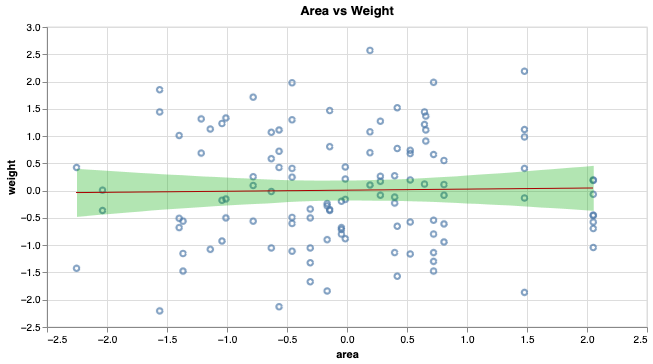

In [27]:
compatibility_band = (
    alt.Chart(df)
    .encode(alt.X("area"))
    .mark_area(opacity=0.3, color="#00AA00")
    .encode(alt.Y("mu_high"), alt.Y2("mu_low"))
)

map_line = (
    alt.Chart(df).mark_line(color="#AA0000", strokeWidth=1).encode(x="area", y="w_map")
)

data_chart = (
    alt.Chart(pd.DataFrame(data), title="Area vs Weight", width=600)
    .mark_point()
    .encode(
        alt.X("area", scale=alt.Scale(zero=False)),
        alt.Y("weight", scale=alt.Scale(zero=False), axis=alt.Axis(title="weight")),
    )
)

data_chart + compatibility_band + map_line

### 5H1. Part 2.

In [28]:
# prepare data (z-scores)
data = {"n": foxes_df.shape[0]}

for col in ["groupsize", "weight"]:
    d = foxes_df[col].to_numpy()
    d = (d - d.mean()) / d.std()
    data[col] = d

In [29]:
# build linear model: weight = f(groupsize)
code = """
data {
  int<lower=0> n;
  vector[n] groupsize;
  vector[n] weight;
}
parameters {
  real alpha;
  real betaG;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 1.0);
  betaG ~ normal(0, 1.0);
  sigma ~ exponential(1);

  // likelihood
  vector[n] mu = alpha + betaG * groupsize;
  weight ~ normal(mu, sigma);
}
"""

In [30]:
%%capture
with suppress_subprocess_output():
    model = stan.build(code, data=data, random_seed=42)
    samples = model.sample(num_chains=4, num_samples=1000)

In [31]:
sample_df = samples.to_frame()
sample_df[["alpha", "betaG", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,0.001281,0.092449,-0.329508,-0.061190,0.001229,0.062313,0.332949
betaG,4000.0,-0.158309,0.091990,-0.499099,-0.220512,-0.158127,-0.097326,0.199350
sigma,4000.0,1.003632,0.067369,0.811858,0.955868,1.000550,1.045092,1.304634


In [32]:
# assume mean and MAP coincide
alpha_mean = sample_df["alpha"].mean()
betaG_mean = sample_df["betaG"].mean()

In [33]:
groupsize_grid = np.linspace(data["groupsize"].min(), data["groupsize"].max())

rows = []
for g in groupsize_grid:
    aa = sample_df["alpha"]
    bb = sample_df["betaG"]
    ss = sample_df["sigma"]

    # sample of weight medians
    mm = aa + bb * g
    mu_low, mu_high = sr.pi(mm, mass=0.95)

    w_map = alpha_mean + betaG_mean * g  # MAP prediction

    row = {
        "groupsize": g,
        "w_map": w_map,
        "mu_low": mu_low,
        "mu_high": mu_high,
    }
    rows.append(row)

df = pd.DataFrame(rows)

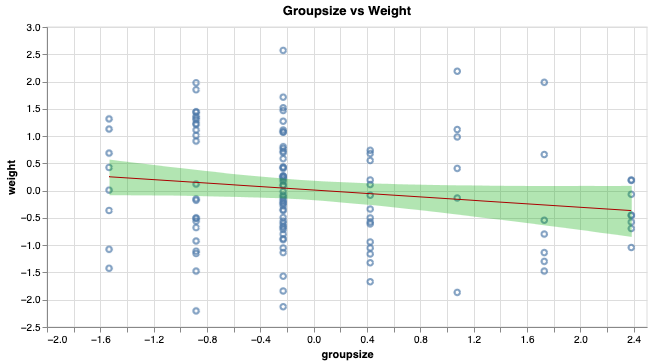

In [34]:
compatibility_band = (
    alt.Chart(df)
    .encode(alt.X("groupsize"))
    .mark_area(opacity=0.3, color="#00AA00")
    .encode(alt.Y("mu_high"), alt.Y2("mu_low"))
)

map_line = (
    alt.Chart(df)
    .mark_line(color="#AA0000", strokeWidth=1)
    .encode(x="groupsize", y="w_map")
)

data_chart = (
    alt.Chart(pd.DataFrame(data), title="Groupsize vs Weight", width=600)
    .mark_point()
    .encode(
        alt.X("groupsize", scale=alt.Scale(zero=False)),
        alt.Y("weight", scale=alt.Scale(zero=False), axis=alt.Axis(title="weight")),
    )
)

data_chart + compatibility_band + map_line

## 5H2

Now fit a multiple linear regression with weight as the outcome and both area and groupsize
as predictor variables. Plot the predictions of the model for each predictor, holding the other predictor
constant at its mean. What does this model say about the importance of each variable? Why do you
get different results than you got in the exercise just above?

In [35]:
# prepare data (z-scores)
data = {"n": foxes_df.shape[0]}

for col in ["area", "groupsize", "weight"]:
    d = foxes_df[col].to_numpy()
    d = (d - d.mean()) / d.std()
    data[col] = d

In [36]:
# build linear model: weight = f(area, groupsize)
code = """
data {
  int<lower=0> n;
  vector[n] area;
  vector[n] groupsize;
  vector[n] weight;
}
parameters {
  real alpha;
  real betaA;
  real betaG;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 1.0);
  betaA ~ normal(0, 1.0);
  betaG ~ normal(0, 1.0);
  sigma ~ exponential(1);

  // likelihood
  vector[n] mu = alpha + betaA * area + betaG * groupsize;
  weight ~ normal(mu, sigma);
}
"""

In [37]:
%%capture
with suppress_subprocess_output():
    model = stan.build(code, data=data, random_seed=42)
    samples = model.sample(num_chains=4, num_samples=1000)

In [38]:
sample_df = samples.to_frame()
sample_df[["alpha", "betaA", "betaG", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,0.001125,0.088953,-0.270619,-0.056754,0.000962,0.057253,0.309126
betaA,4000.0,0.461521,0.157398,-0.088978,0.358659,0.461665,0.565068,0.997973
betaG,4000.0,-0.537077,0.156264,-1.109074,-0.641653,-0.537062,-0.429975,0.000773
sigma,4000.0,0.968837,0.064799,0.776263,0.924310,0.965591,1.009769,1.229062


In [39]:
# assume mean and MAP coincide
alpha_mean = sample_df["alpha"].mean()
betaA_mean = sample_df["betaA"].mean()
betaG_mean = sample_df["betaG"].mean()

In [40]:
area_grid = np.linspace(data["area"].min(), data["area"].max())
groupsize_grid = np.linspace(data["groupsize"].min(), data["groupsize"].max())

area_mean = data["area"].mean()
groupsize_mean = data["groupsize"].mean()

rows = []
for a, g in zip(area_grid, groupsize_grid):
    # predict weight from area
    w1 = (
        sample_df["alpha"]
        + sample_df["betaA"] * a
        + sample_df["betaG"] * groupsize_mean
    )

    # predict weight from groupsize
    w2 = sample_df["alpha"] + sample_df["betaA"] * area_mean + sample_df["betaG"] * g

    # compute probability intervals
    w1_low, w1_high = sr.pi(w1, mass=0.95)
    w2_low, w2_high = sr.pi(w2, mass=0.95)

    w1_mean = alpha_mean + betaA_mean * a + betaG_mean * groupsize_mean
    w2_mean = alpha_mean + betaA_mean * area_mean + betaG_mean * g

    row = {
        "area": a,
        "groupsize": g,
        "w1_mean": w1_mean,
        "w1_low": w1_low,
        "w1_high": w1_high,
        "w2_mean": w2_mean,
        "w2_low": w2_low,
        "w2_high": w2_high,
    }

    rows.append(row)

df = pd.DataFrame(rows)

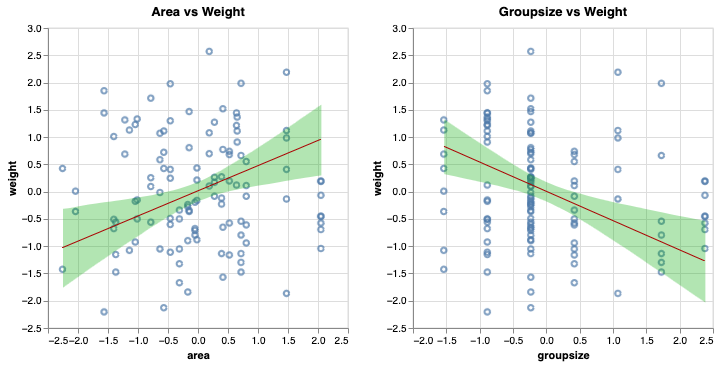

In [41]:
band1 = (
    alt.Chart(df, title="Area vs Weight")
    .encode(alt.X("area"))
    .mark_area(opacity=0.3, color="#00AA00")
    .encode(alt.Y("w1_high", axis=alt.Axis(title="weight")), alt.Y2("w1_low"))
)

line1 = (
    alt.Chart(df)
    .mark_line(color="#AA0000", strokeWidth=1)
    .encode(x="area", y=alt.Y("w1_mean"))
)

points1 = alt.Chart(pd.DataFrame(data)).mark_point().encode(x="area", y="weight")


band2 = (
    alt.Chart(df, title="Groupsize vs Weight")
    .encode(alt.X("groupsize"))
    .mark_area(opacity=0.3, color="#00AA00")
    .encode(alt.Y("w2_high", axis=alt.Axis(title="weight")), alt.Y2("w2_low"))
)

line2 = (
    alt.Chart(df)
    .mark_line(color="#AA0000", strokeWidth=1)
    .encode(x="groupsize", y=alt.Y("w2_mean"))
)

points2 = alt.Chart(pd.DataFrame(data)).mark_point().encode(x="groupsize", y="weight")


(points1 + band1 + line1) | (points2 + band2 + line2)

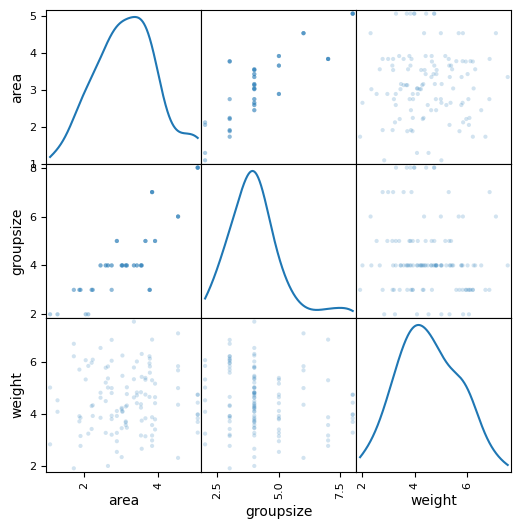

In [42]:
# Area and groupsize are correlated and they have opposite correlation with
# weight which creates masking effect
#
# A────►G
# │     │
# │     ▼
# └────►W

scatter_matrix(
    foxes_df[["area", "groupsize", "weight"]], alpha=0.2, figsize=(6, 6), diagonal="kde"
);

## 5H3

Finally, consider the avgfood variable. Fit two more multiple regressions: (1) body weight
as an additive function of avgfood and groupsize, and (2) body weight as an additive function of
all three variables, avgfood and groupsize and area. Compare the results of these models to the
previous models you’ve fit, in the first two exercises. (a) Is avgfood or area a better predictor of body
weight? If you had to choose one or the other to include in a model, which would it be? Support your
assessment with any tables or plots you choose. (b) When both avgfood or area are in the same
model, their effects are reduced (closer to zero) and their standard errors are larger than when they
are included in separate models. Can you explain this result?

### 5H3.1

In [43]:
# prepare data (z-scores)
data = {"n": foxes_df.shape[0]}

for col in ["avgfood", "groupsize", "weight"]:
    d = foxes_df[col].to_numpy()
    d = (d - d.mean()) / d.std()
    data[col] = d

In [44]:
# build linear model: weight = f(area, groupsize)
code = """
data {
  int<lower=0> n;
  vector[n] avgfood;
  vector[n] groupsize;
  vector[n] weight;
}
parameters {
  real alpha;
  real betaF;
  real betaG;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 1.0);
  betaF ~ normal(0, 1.0);
  betaG ~ normal(0, 1.0);
  sigma ~ exponential(1);

  // likelihood
  vector[n] mu = alpha + betaF * avgfood + betaG * groupsize;
  weight ~ normal(mu, sigma);
}
"""

In [45]:
%%capture
with suppress_subprocess_output():
    model = stan.build(code, data=data, random_seed=42)
    samples = model.sample(num_chains=4, num_samples=1000)

In [46]:
sample_df = samples.to_frame()
sample_df[["alpha", "betaF", "betaG", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,0.000053,0.090337,-0.346705,-0.058860,-0.000763,0.061242,0.317000
betaF,4000.0,0.589496,0.198247,-0.107059,0.459053,0.587393,0.720128,1.378899
betaG,4000.0,-0.687438,0.196879,-1.427146,-0.819798,-0.682808,-0.553119,0.099347
sigma,4000.0,0.964425,0.064543,0.745308,0.920481,0.961360,1.005389,1.209603


In [47]:
# assume mean and MAP coincide
alpha_mean = sample_df["alpha"].mean()
betaF_mean = sample_df["betaF"].mean()
betaG_mean = sample_df["betaG"].mean()

In [48]:
food_grid = np.linspace(data["avgfood"].min(), data["avgfood"].max())
groupsize_grid = np.linspace(data["groupsize"].min(), data["groupsize"].max())

food_mean = data["avgfood"].mean()
groupsize_mean = data["groupsize"].mean()

rows = []
for f, g in zip(food_grid, groupsize_grid):
    # predict weight from avgfood
    w1 = (
        sample_df["alpha"]
        + sample_df["betaF"] * f
        + sample_df["betaG"] * groupsize_mean
    )

    # predict weight from groupsize
    w2 = sample_df["alpha"] + sample_df["betaF"] * food_mean + sample_df["betaG"] * g

    # compute probability intervals
    w1_low, w1_high = sr.pi(w1, mass=0.95)
    w2_low, w2_high = sr.pi(w2, mass=0.95)

    w1_mean = alpha_mean + betaF_mean * f + betaG_mean * groupsize_mean
    w2_mean = alpha_mean + betaF_mean * food_mean + betaG_mean * g

    row = {
        "food": f,
        "groupsize": g,
        "w1_mean": w1_mean,
        "w1_low": w1_low,
        "w1_high": w1_high,
        "w2_mean": w2_mean,
        "w2_low": w2_low,
        "w2_high": w2_high,
    }

    rows.append(row)

df = pd.DataFrame(rows)

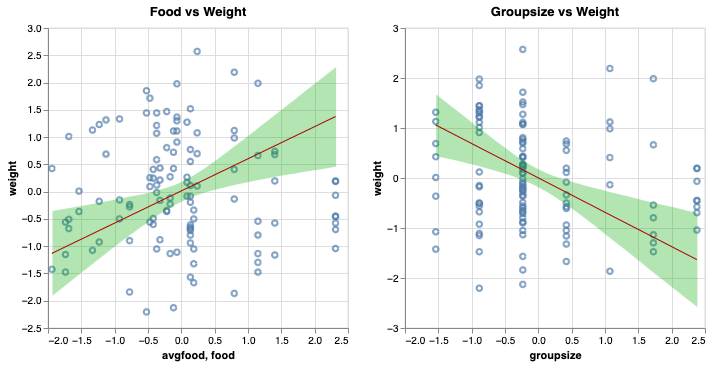

In [49]:
band1 = (
    alt.Chart(df, title="Food vs Weight")
    .encode(alt.X("food"))
    .mark_area(opacity=0.3, color="#00AA00")
    .encode(alt.Y("w1_high", axis=alt.Axis(title="weight")), alt.Y2("w1_low"))
)

line1 = (
    alt.Chart(df)
    .mark_line(color="#AA0000", strokeWidth=1)
    .encode(x="food", y=alt.Y("w1_mean"))
)

points1 = alt.Chart(pd.DataFrame(data)).mark_point().encode(x="avgfood", y="weight")


band2 = (
    alt.Chart(df, title="Groupsize vs Weight")
    .encode(alt.X("groupsize"))
    .mark_area(opacity=0.3, color="#00AA00")
    .encode(alt.Y("w2_high", axis=alt.Axis(title="weight")), alt.Y2("w2_low"))
)

line2 = (
    alt.Chart(df)
    .mark_line(color="#AA0000", strokeWidth=1)
    .encode(x="groupsize", y=alt.Y("w2_mean"))
)

points2 = alt.Chart(pd.DataFrame(data)).mark_point().encode(x="groupsize", y="weight")


(points1 + band1 + line1) | (points2 + band2 + line2)

### 5H3.2

In [50]:
# prepare data (z-scores)
data = {"n": foxes_df.shape[0]}

for col in ["area", "avgfood", "groupsize", "weight"]:
    d = foxes_df[col].to_numpy()
    d = (d - d.mean()) / d.std()
    data[col] = d

In [51]:
# build linear model: weight = f(area, groupsize)
code = """
data {
  int<lower=0> n;
  vector[n] area;
  vector[n] avgfood;
  vector[n] groupsize;
  vector[n] weight;
}
parameters {
  real alpha;
  real betaA;
  real betaF;
  real betaG;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(0, 1.0);
  betaA ~ normal(0, 1.0);
  betaF ~ normal(0, 1.0);
  betaG ~ normal(0, 1.0);
  sigma ~ exponential(1);

  // likelihood
  vector[n] mu = alpha + betaA * area + betaF * avgfood + betaG * groupsize;
  weight ~ normal(mu, sigma);
}
"""

In [52]:
%%capture
with suppress_subprocess_output():
    model = stan.build(code, data=data, random_seed=42)
    samples = model.sample(num_chains=4, num_samples=1000)

In [53]:
sample_df = samples.to_frame()
sample_df[["alpha", "betaA", "betaF", "betaG", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha,4000.0,-0.000506,0.090092,-0.286961,-0.061333,-0.000393,0.059424,0.290449
betaA,4000.0,0.295249,0.188661,-0.407418,0.171678,0.293946,0.421131,0.941354
betaF,4000.0,0.376757,0.241820,-0.467119,0.213875,0.375157,0.543664,1.185784
betaG,4000.0,-0.739307,0.199929,-1.598421,-0.875417,-0.742956,-0.605970,0.038921
sigma,4000.0,0.958541,0.062914,0.778522,0.914530,0.954507,0.998889,1.205384


In [54]:
# assume mean and MAP coincide
alpha_mean = sample_df["alpha"].mean()
betaA_mean = sample_df["betaA"].mean()
betaF_mean = sample_df["betaF"].mean()
betaG_mean = sample_df["betaG"].mean()

In [55]:
# TODO: build abstractions to simplify this code
area_grid = np.linspace(data["area"].min(), data["area"].max())
food_grid = np.linspace(data["avgfood"].min(), data["avgfood"].max())
groupsize_grid = np.linspace(data["groupsize"].min(), data["groupsize"].max())

area_mean = data["area"].mean()
food_mean = data["avgfood"].mean()
groupsize_mean = data["groupsize"].mean()

rows = []
for a, f, g in zip(area_grid, food_grid, groupsize_grid):
    # predict weight from area
    w1 = (
        sample_df["alpha"]
        + sample_df["betaA"] * a
        + sample_df["betaF"] * food_mean
        + sample_df["betaG"] * groupsize_mean
    )

    # predict weight from avgfood
    w2 = (
        sample_df["alpha"]
        + sample_df["betaA"] * area_mean
        + sample_df["betaF"] * f
        + sample_df["betaG"] * groupsize_mean
    )

    # predict weight from groupsize
    w3 = (
        sample_df["alpha"]
        + sample_df["betaA"] * area_mean
        + sample_df["betaF"] * food_mean
        + sample_df["betaG"] * g
    )

    # compute probability intervals
    w1_low, w1_high = sr.pi(w1, mass=0.95)
    w2_low, w2_high = sr.pi(w2, mass=0.95)
    w3_low, w3_high = sr.pi(w3, mass=0.95)

    w1_mean = (
        alpha_mean
        + betaA_mean * a
        + betaF_mean * food_mean
        + betaG_mean * groupsize_mean
    )
    w2_mean = (
        alpha_mean
        + betaA_mean * area_mean
        + betaF_mean * f
        + betaG_mean * groupsize_mean
    )
    w3_mean = (
        alpha_mean + betaA_mean * area_mean + betaF_mean * food_mean + betaG_mean * g
    )

    row = {
        "area": a,
        "food": f,
        "groupsize": g,
        # weight = f(area)
        "w1_mean": w1_mean,
        "w1_low": w1_low,
        "w1_high": w1_high,
        # weight = f(food)
        "w2_mean": w2_mean,
        "w2_low": w2_low,
        "w2_high": w2_high,
        # weight = f(groupsize)
        "w3_mean": w3_mean,
        "w3_low": w3_low,
        "w3_high": w3_high,
    }

    rows.append(row)

df = pd.DataFrame(rows)

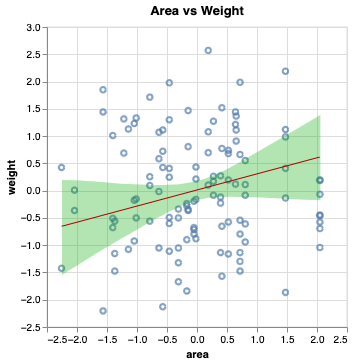

In [56]:
band1 = (
    alt.Chart(df, title="Area vs Weight")
    .encode(alt.X("area"))
    .mark_area(opacity=0.3, color="#00AA00")
    .encode(alt.Y("w1_high", axis=alt.Axis(title="weight")), alt.Y2("w1_low"))
)

line1 = (
    alt.Chart(df)
    .mark_line(color="#AA0000", strokeWidth=1)
    .encode(x="area", y=alt.Y("w1_mean"))
)

points1 = alt.Chart(pd.DataFrame(data)).mark_point().encode(x="area", y="weight")


points1 + band1 + line1

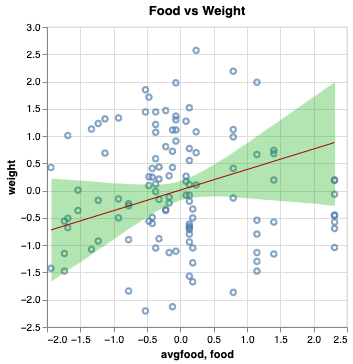

In [57]:
band2 = (
    alt.Chart(df, title="Food vs Weight")
    .encode(alt.X("food"))
    .mark_area(opacity=0.3, color="#00AA00")
    .encode(alt.Y("w2_high", axis=alt.Axis(title="weight")), alt.Y2("w2_low"))
)

line2 = (
    alt.Chart(df)
    .mark_line(color="#AA0000", strokeWidth=1)
    .encode(x="food", y=alt.Y("w2_mean"))
)

points2 = alt.Chart(pd.DataFrame(data)).mark_point().encode(x="avgfood", y="weight")


points2 + band2 + line2

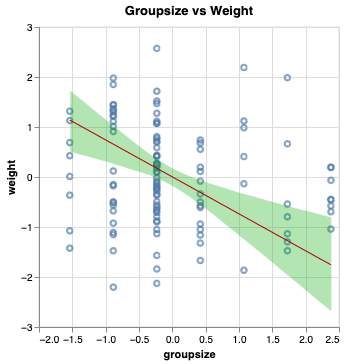

In [58]:
band3 = (
    alt.Chart(df, title="Groupsize vs Weight")
    .encode(alt.X("groupsize"))
    .mark_area(opacity=0.3, color="#00AA00")
    .encode(alt.Y("w3_high", axis=alt.Axis(title="weight")), alt.Y2("w3_low"))
)

line3 = (
    alt.Chart(df)
    .mark_line(color="#AA0000", strokeWidth=1)
    .encode(x="groupsize", y=alt.Y("w3_mean"))
)

points3 = alt.Chart(pd.DataFrame(data)).mark_point().encode(x="groupsize", y="weight")

points3 + band3 + line3

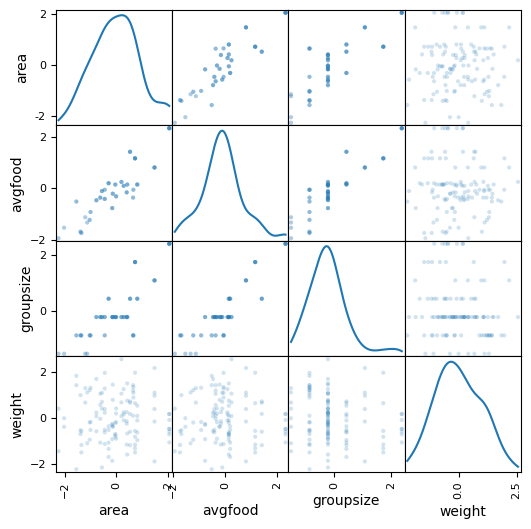

In [59]:
df = pd.DataFrame(data)
df = df.drop("n", axis=1)
scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal="kde");